<h1>Process Data</h1>
<h4>Haley Johnson</h4>

<p>Notebook to extract, combine and transform data</p>

In [168]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import statsmodels.api as sm
from statsmodels.stats.api import anova_lm
from statsmodels.formula.api import ols
import os 
from scipy.stats import pearsonr

In [2]:
sns.set_style("darkgrid")
sns.color_palette("husl", 9)
sns.set_context("poster")
sns.set(font_scale = 1)

<h2>Manipulate Happiness Data</h2>

In [3]:
html = pd.read_html("happiest_cities.html")

In [4]:
happiness_df = html[0]

In [5]:
happiness_df = happiness_df.rename(columns = {'City': 'Location', 'Total Score': 'total_score', 
                                              'Emotional & Physical Well-Being':'emotional_physical_wellbeing', 
                                              'Income & Employment': 'income_employment', 
                                              'Community & Environment': 'community_environment'})

happiness_df['state'] = happiness_df['Location'].apply(lambda s: s.split(",")[-1])
happiness_df['city'] = happiness_df['Location'].apply(lambda s: s.split(",")[0])

happiness_df = happiness_df.drop(columns = ['Location'])

In [6]:
happiness_df['state'] = happiness_df['state'].str.strip().str.upper()
happiness_df['city'] = happiness_df['city'].str.strip().str.upper()

<h2>Manipulate Transportation Data</h2>

In [7]:
locations_df = pd.read_csv("EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv")

<h4>Remove Rows Where Location Is Missing</h4>

In [8]:
locations_df = locations_df[pd.isnull(locations_df['CBSA_Name']) == False]

In [9]:
for col in list(locations_df.columns):
    subset = locations_df[col]
    counts = pd.isnull(subset)
    counts = counts.value_counts()
    if True in counts.values:
        print(f"{col} contains missing values")

<h4>Missing Values in D4A column</h4>
<p>D4A measures the distance from the population center to the nearest transit stop. If there are not transit stops in that area, the value is reported as -9999.99</p>

In [145]:
locations_df['D4A'] = locations_df['D4A'].replace(-99999.00, None)

<h4>Setting Ranking Columns as Category</h4>

In [146]:
rankings = ['D2A_Ranked', 'D2B_Ranked', 'D3B_Ranked', 'D4A_Ranked']

for rank in rankings:
    locations_df[rank] = locations_df[rank].astype('category')

<h4>Get City and State Names</h4>

In [147]:
locations_df['CBSA_Name'] = locations_df['CBSA_Name'].astype(str)

In [148]:
locations_df['metro_area_cities'] = locations_df['CBSA_Name'].apply(lambda s: str(s).split(",")[0])
locations_df['metro_area_states'] = locations_df['CBSA_Name'].apply(lambda s: str(s).split(",")[-1])

locations_df['city'] = locations_df['metro_area_cities'].apply(lambda s: s.split("-"))
locations_df['state'] = locations_df['metro_area_states'].apply(lambda s: s.split("-"))

In [149]:
locations_df = locations_df.drop(columns = ['metro_area_cities', 'metro_area_states'])

<h3>Explode</h3>

In [150]:
exploded = locations_df.explode('city')
exploded = exploded.explode('state')
exploded = exploded.drop_duplicates()

In [151]:
exploded['city'] = exploded['city'].str.strip().str.upper()
exploded['state'] = exploded['state'].str.strip().str.upper()

<h2>Joining Happiness and Transportation Dataframes</h2>

<h4>Check that columns match</h4>

<p><b>St. Paul Minnestoa</b></p>

In [152]:
happiness_df[happiness_df['state'] == 'MN'][['city', 'state']]

,city,state
11,MINNEAPOLIS,MN
45,ST. PAUL,MN


In [153]:
exploded[exploded['state'] == 'MN'][['city', 'state']].sample(10)

,city,state
125383,MINNEAPOLIS,MN
128726,ST. PAUL,MN
125315,MINNEAPOLIS,MN
215656,ST. PAUL,MN
125671,ST. PAUL,MN
128153,MINNEAPOLIS,MN
128995,MINNEAPOLIS,MN
126404,BLOOMINGTON,MN
126238,DULUTH,MN
127536,BLOOMINGTON,MN


<p><b>New York City, NY</b></p>

In [154]:
happiness_df[happiness_df['state'] == 'NY'][['city', 'state']]

,city,state
43,YONKERS,NY
57,NEW YORK,NY
130,ROCHESTER,NY
135,BUFFALO,NY


In [155]:
exploded[exploded['state'] == 'NY'][['city', 'state']].sample(10)

,city,state
146840,NEW YORK,NY
162079,ROCHESTER,NY
150118,NEWARK,NY
162722,NEWARK,NY
159244,NEWARK,NY
157199,NEW YORK,NY
146103,NEWARK,NY
163381,NEWARK,NY
144278,NEWARK,NY
141864,NEWARK,NY


<p><b>Washington, D.C.</b></p>

In [156]:
happiness_df[happiness_df['state'] == 'DC'][['city', 'state']]

,city,state
84,WASHINGTON,DC


In [157]:
happiness_df[happiness_df['city'] == 'Arlington'][['city', 'state']]

,city,state


In [158]:
happiness_df[happiness_df['city'] == 'Alexandria'][['city', 'state']]

,city,state


In [159]:
exploded[exploded['state'] == 'DC'][['city', 'state']].sample(10)

,city,state
17304,WASHINGTON,DC
111444,ALEXANDRIA,DC
111639,ALEXANDRIA,DC
108405,ARLINGTON,DC
110276,ARLINGTON,DC
15917,ARLINGTON,DC
109697,ALEXANDRIA,DC
108917,ALEXANDRIA,DC
61603,WASHINGTON,DC
20492,WASHINGTON,DC


<h4>Joining</h4>

In [160]:
matches = exploded.merge(happiness_df, on = ['state', 'city'])

In [161]:
# NOTE TO SELF: When you add new columns up above, you need to adjust these 
vals = list(matches.columns)[11:-8] + list(happiness_df.columns)[:-2]
df = pd.pivot_table(matches, index = ['city', "state"], values = vals, aggfunc = 'mean')

In [162]:
df = df.reset_index()

<h4>Add in Regions</h4>

<p>Based on <a href="https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf">census designations</a></p>

In [27]:
regions = {}

regions['Pacific'] = ['CA', 'OR', 'WA', 'HI', 'AK']

regions['Mountain West'] = ['ID', 'NV', 'MT','WY', 'UT', 'CO', 'AZ', 'NM']

regions['West North Central'] = ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO']

regions['West South Central'] = ['TX', 'OK', 'AR', 'LA']

regions['East North Central'] = ['WI', 'IL', 'MI', 'IN', 'OH']

regions['East South Central'] = ['KY', 'TN', 'MS', 'AL']

regions['South Atlantiic'] = ['FL', 'GA', 'SC', 'NC', 'VA', 'WV', 'DC', 'MD', 'DE']

regions['Middle Atlantic'] = ['PA', 'NY', 'NJ']

regions['New England'] = ['ME', 'VT', 'NH', 'MA', 'CT', 'RI']

regions['US Territories'] = ['PR']

In [28]:
def get_region(s):
    keys = list(regions.keys())
    for key in keys:
        if s in regions[key]:
            return key
    return None

In [29]:
df['Region'] = df['state'].apply(get_region)

<h2>Data Visualization</h2>

<h3>Example of Why Aggregation Is Helpful</h3>

<p>Credit to <a href = "https://matplotlib.org/stable/gallery/text_labels_and_annotations/annotation_demo.html">this</a> MatPlotLib tutorial for helping me annotate my plots</p>

Text(0.5, 0.98, 'Effect of Aggregating by City on Analysis')

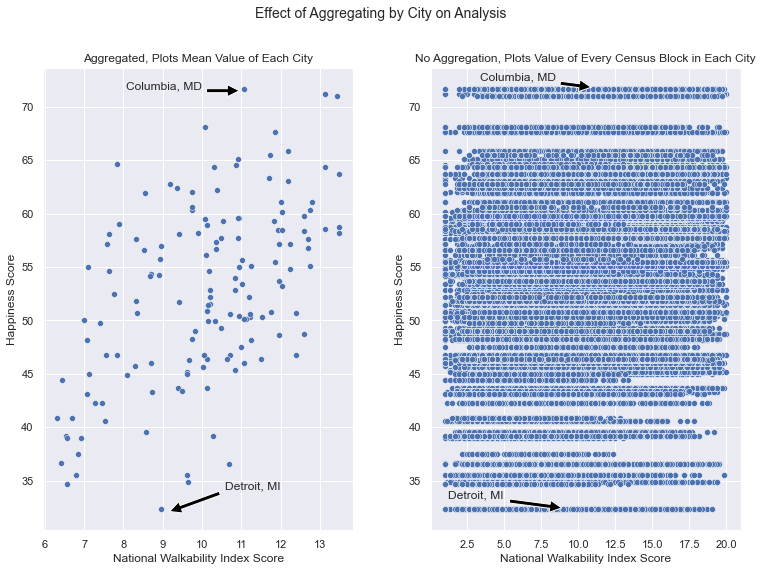

In [107]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12.5, 8.5)
fig.subplots_adjust(hspace=0.5, wspace = 0.25)

sns.scatterplot(x = 'NatWalkInd', y = 'total_score', data = df, ax = axes[0])
sns.scatterplot(x = 'NatWalkInd', y = 'total_score', data = matches, ax = axes[1])

# labels
axes[0].set_title('Aggregated, Plots Mean Value of Each City')
axes[0].set(ylabel = 'Happiness Score', xlabel = 'National Walkability Index Score')
axes[1].set_title('No Aggregation, Plots Value of Every Census Block in Each City')
axes[1].set(ylabel = 'Happiness Score', xlabel = 'National Walkability Index Score')

# annotations
axes[0].annotate('Detroit, MI',
            xy=(9.1, 32), xycoords='data',
            xytext=(12, 34), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom')
axes[0].annotate('Columbia, MD',
            xy=(11, 71.5), xycoords='data',
            xytext=(10, 71.5), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom')

axes[1].annotate('Detroit, MI',
            xy=(9.1, 32.4), xycoords='data',
            xytext=(5, 33.15), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom')
axes[1].annotate('Columbia, MD',
            xy=(11, 71.8), xycoords='data',
            xytext=(8.5, 72.25), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom')

fig.suptitle("Effect of Aggregating by City on Analysis", fontsize = 14)

<h3>General Relationship Between Transit, Walkability & Happinness</h3>

Text(0.5, 0.98, 'Relationship Between Transit, Walkability, and Happiness')

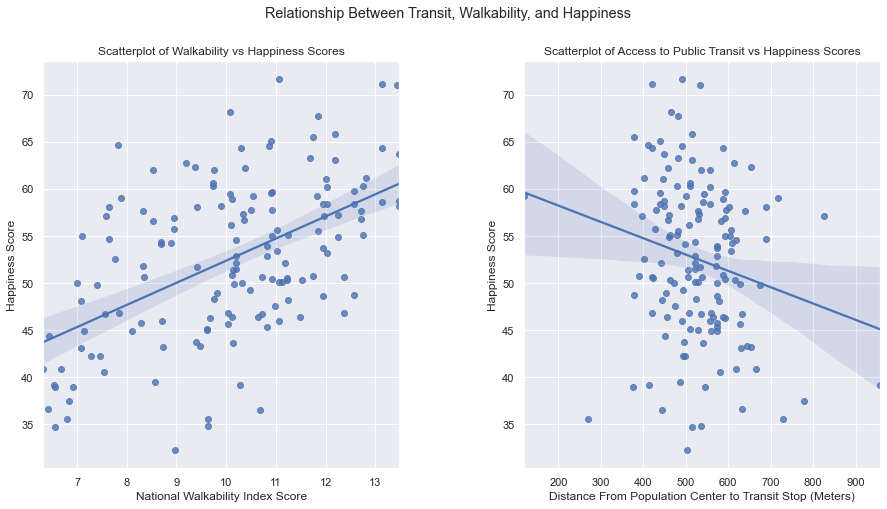

In [176]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15, 7.5)
fig.subplots_adjust(hspace = 0.5, wspace = 0.35)

axes[0] = sns.regplot(x = 'NatWalkInd', y = 'total_score', data = df, ax = axes[0])
axes[0].set(xlabel = 'National Walkability Index Score', ylabel = 'Happiness Score')
axes[0].set_title("Scatterplot of Walkability vs Happiness Scores")

axes[1] = sns.regplot(x = 'D4A', y = 'total_score', data = df, ax = axes[1])
axes[1].set(xlabel = 'Distance From Population Center to Transit Stop (Meters)', ylabel = 'Happiness Score')
axes[1].set_title("Scatterplot of Access to Public Transit vs Happiness Scores")

fig.suptitle("Relationship Between Transit, Walkability, and Happiness")

<p>Credit to <a href = "https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/">this</a> tutrial for helping me calculate correlation</p>

In [174]:
corr, _ = pearsonr(df['total_score'], df['D4A'])
print(corr)

-0.2046791238931847


In [171]:
corr, _ = pearsonr(df['total_score'], df['NatWalkInd'])
print(corr)

0.5252033893429153


Text(0.5, 1.0, 'Scatterplot of Walkability vs Happiness Scores')

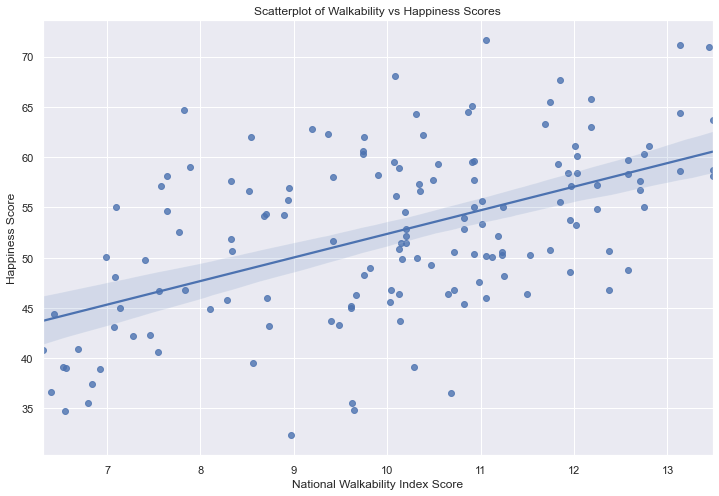

In [32]:
rcParams['figure.figsize'] = 12,8
g = sns.regplot(x = 'NatWalkInd', y = 'total_score', data = df)
g.set(xlabel = 'National Walkability Index Score', ylabel = 'Happiness Score')
g.set_title("Scatterplot of Walkability vs Happiness Scores")

<h3>Access to Public Transit vs Happiness</h3>

Text(0.5, 1.0, 'Scatterplot of Access to Public Transit vs Happiness Scores (Meters)')

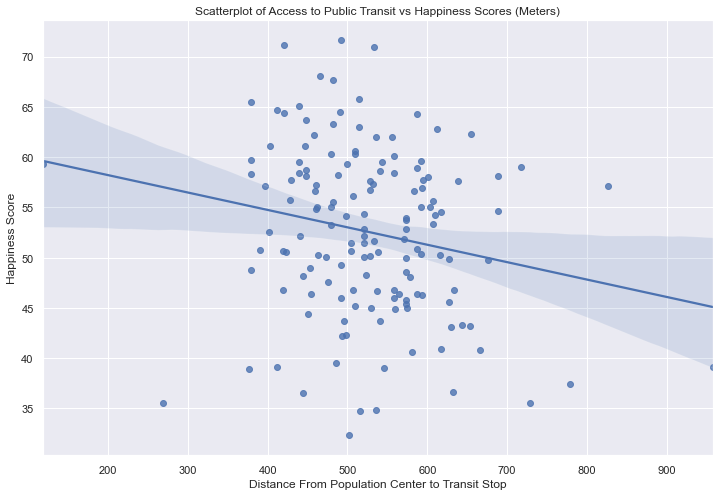

In [166]:
rcParams['figure.figsize'] = 12,8
g = sns.regplot(x = 'D4A', y = 'total_score', data = df)
g.set(xlabel = 'Distance From Population Center to Transit Stop', ylabel = 'Happiness Score')
g.set_title("Scatterplot of Access to Public Transit vs Happiness Scores (Meters)")

<h3>Population vs Happiness Scores</h3>

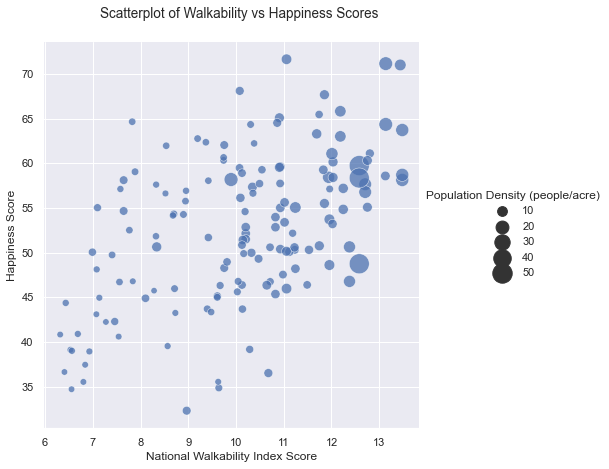

In [110]:
df = df.rename(columns = {'D1B' : 'Population Density (people/acre)'})

g = sns.relplot(x = "NatWalkInd", y = "total_score", size = "Population Density (people/acre)",
            sizes = (40, 400), alpha = 0.75, palette = "muted", 
            height = 6, data = df)


g.set(xlabel = 'National Walkability Index Score', ylabel = 'Happiness Score')
g.fig.suptitle("Scatterplot of Walkability vs Happiness Scores", y = 1.05, x = 0.4, fontsize = 13.5)
df = df.rename(columns = {'Population Density (people/acre)': 'D1B'})

<h4>Statistical Test for Impact of Population on Walkability</h4>

In [112]:
pop_lm = ols('total_score ~ D1B + NatWalkInd', data = df).fit()

print(pop_lm.summary())

                            OLS Regression Results                            
Dep. Variable:            total_score   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     27.43
Date:                Thu, 07 Apr 2022   Prob (F-statistic):           8.08e-11
Time:                        15:01:46   Log-Likelihood:                -496.42
No. Observations:                 147   AIC:                             998.8
Df Residuals:                     144   BIC:                             1008.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.9934      3.589      8.079      0.0

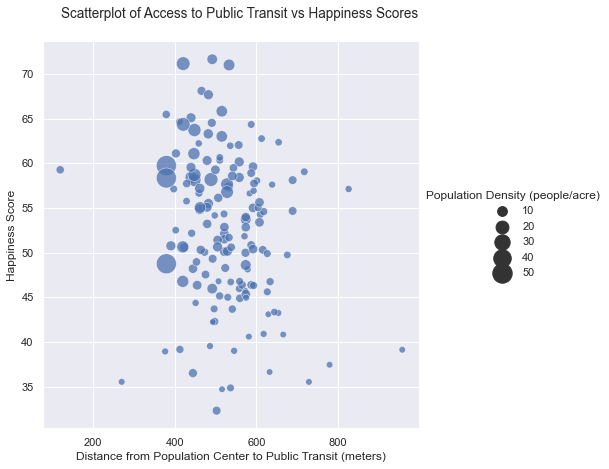

In [182]:
df = df.rename(columns = {'D1B' : 'Population Density (people/acre)'})
g = sns.relplot(x = "D4A", y = "total_score", size = "Population Density (people/acre)",
            sizes = (40, 400), alpha = 0.75, palette = "muted", 
            height = 6, data = df)

g.set(xlabel = 'Distance from Population Center to Public Transit (meters)', ylabel = 'Happiness Score')
g.fig.suptitle("Scatterplot of Access to Public Transit vs Happiness Scores", y = 1.05, x = 0.4, fontsize = 13.5)
df = df.rename(columns = {'Population Density (people/acre)': 'D1B'})

<h4>Statistical Test for Impact of Population on Access to Transit</h4>

In [183]:
pop_lm = ols('total_score ~ D1B + D4A', data = df).fit()

print(pop_lm.summary())

                            OLS Regression Results                            
Dep. Variable:            total_score   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     8.572
Date:                Thu, 07 Apr 2022   Prob (F-statistic):           0.000304
Time:                        15:58:44   Log-Likelihood:                -511.87
No. Observations:                 147   AIC:                             1030.
Df Residuals:                     144   BIC:                             1039.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     54.8369      4.153     13.203      0.0

<h3>Walkability vs Density</h3>

Text(0.5, 1.0, 'Scatterplot of Walkability vs Population Density')

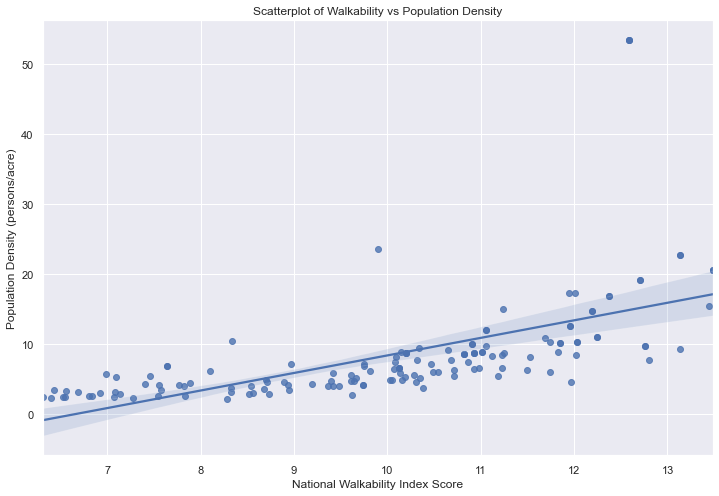

In [114]:
rcParams['figure.figsize'] = 12,8
g = sns.regplot(x = 'NatWalkInd', y = 'D1B', data = df)
g.set(xlabel = 'National Walkability Index Score', ylabel = 'Population Density (persons/acre)')
g.set_title("Scatterplot of Walkability vs Population Density")

<h3>Access to Transit vs Density</h3>

Text(0.5, 1.0, 'Scatterplot of Walkability vs Population Density')

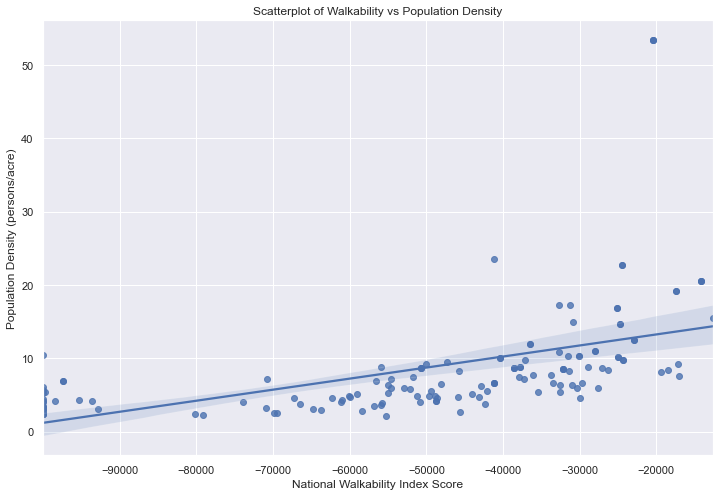

In [121]:
rcParams['figure.figsize'] = 12,8
g = sns.regplot(x = 'D4A', y = 'D1B', data = df)
g.set(xlabel = 'National Walkability Index Score', ylabel = 'Population Density (persons/acre)')
g.set_title("Scatterplot of Walkability vs Population Density")

<h3>Variations by Region</h3>

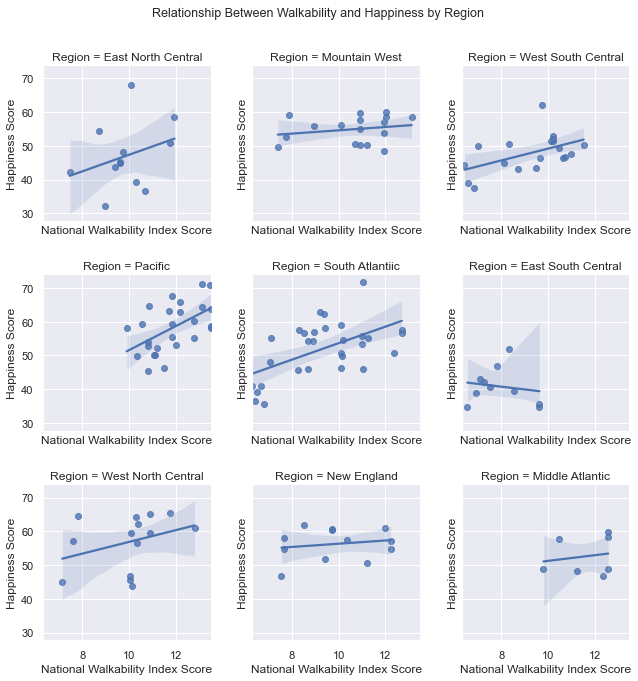

In [34]:
g = sns.FacetGrid(df, col = "Region", col_wrap = 3)
g.map(sns.regplot, "NatWalkInd", "total_score")
g.set(xlabel = 'National Walkability Index Score', ylabel = 'Happiness Score')

g.fig.suptitle("Relationship Between Walkability and Happiness by Region", y = 1.05, fontsize = 12.5)
g.fig.subplots_adjust(wspace = 0.25, hspace = 0.35)

In [35]:
by_region = df.groupby('Region')
happiness_by_region = by_region.describe()['total_score'].sort_values(by = 'mean', ascending = False)
happiness_by_region = happiness_by_region.rename(columns = {'mean': 'average_happiness_score'})

walkability_by_region = by_region.describe()['NatWalkInd'].sort_values(by = 'mean', ascending = False)
walkability_by_region = walkability_by_region.rename(columns = {'mean': 'average_walkability_score'})

happiness_by_region = happiness_by_region['average_happiness_score']
walkability_by_region = walkability_by_region['average_walkability_score']

regional_variations = pd.concat([happiness_by_region, walkability_by_region], axis = 1)

In [36]:
regional_variations

,average_happiness_score,average_walkability_score
Region,,
Pacific,58.197692,11.856247
West North Central,56.905000,10.016230
New England,56.260000,9.863358
Mountain West,54.908824,10.636201
Middle Atlantic,52.642857,11.668197
South Atlantiic,51.932667,9.306112
West South Central,47.870000,9.262742
East North Central,47.002500,9.851519
East South Central,40.815000,7.936037


<h4>Statistical Tests for Different in Mean Across Regions</h4>

In [54]:
lm = ols('total_score ~ NatWalkInd', data = df).fit()
regions_lm = ols('total_score ~ Region + NatWalkInd', data = df).fit()

table1 = anova_lm(lm, regions_lm)
print(table1)

   df_resid          ssr  df_diff      ss_diff         F    Pr(>F)
0     145.0  7380.089644      0.0          NaN       NaN       NaN
1     137.0  5658.967775      8.0  1721.121869  5.208408  0.000011


In [55]:
print(regions_lm.summary())

                            OLS Regression Results                            
Dep. Variable:            total_score   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     12.19
Date:                Thu, 07 Apr 2022   Prob (F-statistic):           5.05e-14
Time:                        12:58:53   Log-Likelihood:                -476.90
No. Observations:                 147   AIC:                             973.8
Df Residuals:                     137   BIC:                             1004.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

<h3>Pedestrian Intersections</h3>

Text(0.5, 1.0, 'Figure 3: 1-20 Ranking of Density \n of Pedestrian Street Intersections')

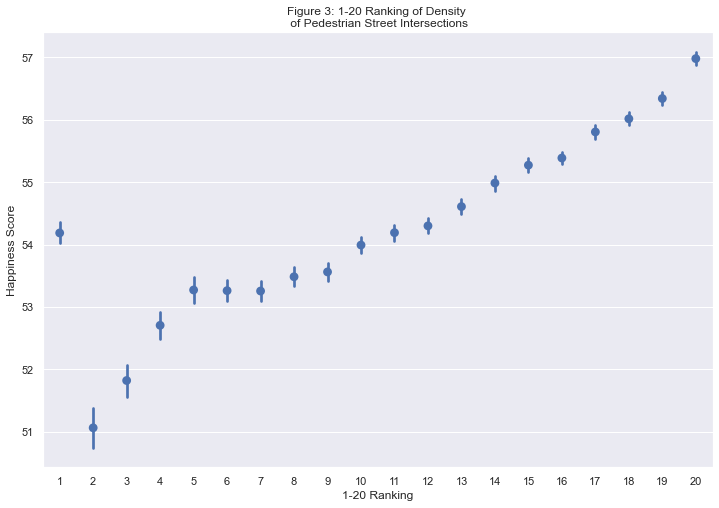

In [190]:
g = sns.pointplot(x = 'D3B_Ranked', y = 'total_score', data = matches, join = False)
g.set_xticklabels(g.get_xticklabels())
g.set_xlabel(xlabel = '1-20 Ranking')
g.set_ylabel('Happiness Score')
g.set_title('Ranking of Density \n of Pedestrian Street Intersections')

<h3>Pedestrian Intersections and Houses without Cars</h3>

<AxesSubplot:xlabel='Pct_AO0', ylabel='D3B_Ranked'>

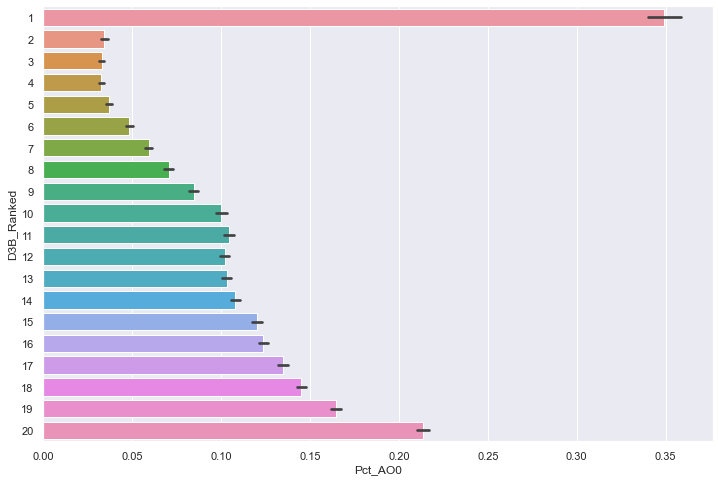

In [198]:
sns.barplot(x = 'Pct_AO0', y = 'D3B_Ranked', data = matches)

In [191]:
# rip my magnum opus
# fig, axes = plt.subplots(2, 2)
# fig.set_size_inches(15, 10)
# fig.subplots_adjust(hspace=0.5, wspace = 0.25)

# targets = ['D2A_Ranked', 'D2B_Ranked', 'D3B_Ranked', 'D4A_Ranked']

# for i, ax in enumerate(axes.flatten()):
#     g = sns.pointplot(x = targets[i], y = 'total_score', data = matches, join = False, ax = ax)
#     g.set_xticklabels(g.get_xticklabels())
#     g.set_xlabel(xlabel = '1-20 Ranking')
#     g.set_ylabel('Happiness Score')
    
# # set titles
# axes[0][0].set_title('Figure 1: 1-20 Ranking of Number of \n Walking Trips to Tier 5 Employment Jobs')
# axes[0][1].set_title('Figure 2: 1-20 Ranking of Number of \n Walking Trips to Tier 8 Employment Jobs')
# axes[1][0].set_title('Figure 3: 1-20 Ranking of Density \n of Pedestrian Street Intersections')
# axes[1][1].set_title('Figure 4: 1-20 Ranking of Distance \n From Population Center to Nearest Transit Stop')

# fig.suptitle("Happiness Scores vs Walkability Index Ranking", fontsize = 15)